In [1]:
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from collections import OrderedDict

In [2]:
# Download the dataset
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

mnist_data = datasets.MNIST(
    root="../data/raw/",
    train=True,
    transform=transforms.ToTensor(),
    download=True,
)
dataloader = DataLoader(mnist_data, batch_size=32, shuffle=True)

2.0%

100.0%


Extracting ../data/raw/MNIST/raw/train-images-idx3-ubyte.gz to ../data/raw/MNIST/raw



100.0%

Extracting ../data/raw/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/raw/MNIST/raw




65.6%

100.0%
100.0%


Extracting ../data/raw/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/raw/MNIST/raw

Extracting ../data/raw/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/raw/MNIST/raw



In [9]:
# Check the quantity of the dataset
total_data = 0

for data, label in dataloader:
    total_data+=data.shape[0]

print("Total number of dataset # {} ".format(total_data))
print("The shape of the dataset # {} ".format(data.shape))

Total number of dataset # 60000 
The shape of the dataset # torch.Size([32, 1, 28, 28]) 


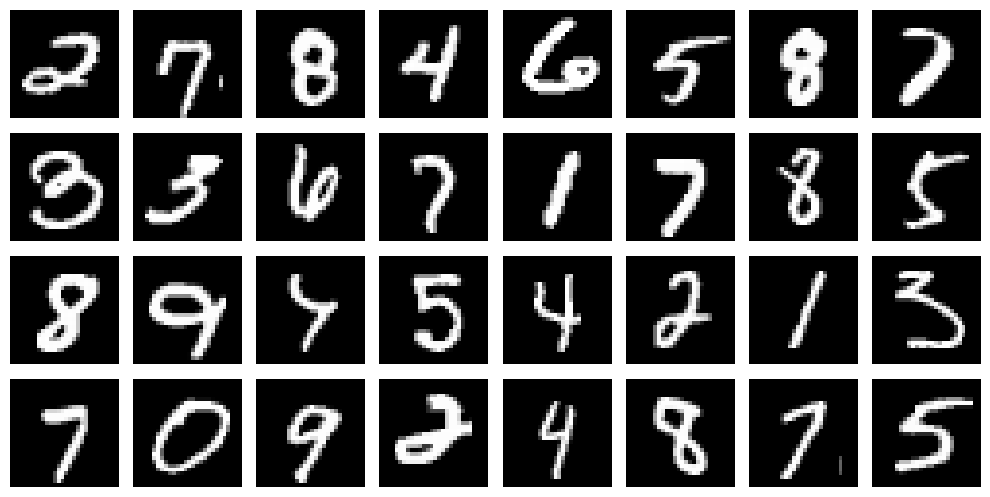

In [11]:
# Display the dataset

images, _ = next(iter(dataloader))
plt.figure(figsize=(10, 10))

for index, image in enumerate(images):
    plt.subplot(8, 8, index + 1)
    plt.imshow(image.view(28, 28), cmap="gray")
    plt.axis("off")
    
plt.tight_layout()
plt.show()

In [38]:
def calculate_params(model):
    total_params = 0
    for layer, params in model.named_parameters():
        print("Layer # {} & params # {} ".format(layer, params.numel()))
        total_params += params.numel()

    return total_params

In [36]:
# Generator model
class Generator(nn.Module):
    def __init__(self, latent_space=100):
        self.latent_space = latent_space
        super(Generator, self).__init__()

        self.layers_config = [
            (self.latent_space, 256, 0.2),
            (256, 512, 0.2),
            (512, 1024, 0.2),
            (1024, 28 * 28),
        ]
        self.model = self.connected_layer(self.layers_config)

    def connected_layer(self, layers_config=None):
        layers = OrderedDict()

        if layers_config is not None:
            for index, (in_features, out_features, negative_slope) in enumerate(
                layers_config[:-1]
            ):
                layers["{}_layer".format(index)] = nn.Linear(
                    in_features=in_features, out_features=out_features
                )
                layers["{}_activation".format(index)] = nn.LeakyReLU(
                    negative_slope=negative_slope
                )

            (in_features, out_features) = layers_config[-1]
            layers["out_layer"] = nn.Linear(
                in_features=in_features, out_features=out_features
            )

            return nn.Sequential(layers)

        else:
            raise Exception("Layers is not defined in the Geneator".capitalize())

    def forward(self, x):
        if x is not None:
            x = self.model(x)
        else:
            raise Exception("Input is not defined in the Genearator".capitalize())
        return x.reshape(-1, 1, 28, 28)

In [41]:
# Critic Model

class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.layers_config = [
            (28*28, 1024, 0.2),
            (1024, 512, 0.2),
            (512, 256, 0.2),
            (256, 1)
        ]
        self.model = self.connected_layer(self.layers_config)
    def connected_layer(self, layers_config = None):
        layers = OrderedDict()
        
        if layers_config is not None:
            for index, (in_features, out_features, negative_slope) in enumerate(layers_config[:-1]):
                layers["{}_layer".format(index)] = nn.Linear(
                    in_features = in_features, out_features = out_features)
                layers["{}_activation".format(index)] = nn.LeakyReLU(
                    negative_slope = negative_slope)
            
            (in_features, out_features) = layers_config[-1]
            layers["out_layer"] = nn.Linear(
                in_features = in_features, out_features = out_features)
            
            return nn.Sequential(layers)
        
        else:
            raise Exception("Layers is not defined in the Critic".capitalize())
    
    def forward(self, x):
        if x is not None:
            x = x.reshape(-1, 28*28)
            x = self.model(x)
        else:
            raise Exception("Input is not defined in the Critic".capitalize())
        return x

In [42]:
# Call the Generator
if __name__ == "__main__":
    generator = Generator()
    print(generator)

Generator(
  (model): Sequential(
    (0_layer): Linear(in_features=100, out_features=256, bias=True)
    (0_activation): LeakyReLU(negative_slope=0.2)
    (1_layer): Linear(in_features=256, out_features=512, bias=True)
    (1_activation): LeakyReLU(negative_slope=0.2)
    (2_layer): Linear(in_features=512, out_features=1024, bias=True)
    (2_activation): LeakyReLU(negative_slope=0.2)
    (out_layer): Linear(in_features=1024, out_features=784, bias=True)
  )
)


In [43]:
# Call the Critic
if __name__ == '__main__':
    critic = Critic()
    print(critic)

Critic(
  (model): Sequential(
    (0_layer): Linear(in_features=784, out_features=1024, bias=True)
    (0_activation): LeakyReLU(negative_slope=0.2)
    (1_layer): Linear(in_features=1024, out_features=512, bias=True)
    (1_activation): LeakyReLU(negative_slope=0.2)
    (2_layer): Linear(in_features=512, out_features=256, bias=True)
    (2_activation): LeakyReLU(negative_slope=0.2)
    (out_layer): Linear(in_features=256, out_features=1, bias=True)
  )
)


In [44]:
# Total parameters of the Critic
print("\nTotal parameters of the Generator: {}".format(calculate_params(critic)).upper())

Layer # model.0_layer.weight & params # 802816 
Layer # model.0_layer.bias & params # 1024 
Layer # model.1_layer.weight & params # 524288 
Layer # model.1_layer.bias & params # 512 
Layer # model.2_layer.weight & params # 131072 
Layer # model.2_layer.bias & params # 256 
Layer # model.out_layer.weight & params # 256 
Layer # model.out_layer.bias & params # 1 

TOTAL PARAMETERS OF THE GENERATOR: 1460225


In [45]:
# Check it works or not

noise_data = torch.randn(64, 100)
generator(noise_data).shape

torch.Size([64, 1, 28, 28])

In [46]:
# Total parameters of the Critic
print("\nTotal parameters of the Critic: {}".format(calculate_params(critic)).upper())

Layer # model.0_layer.weight & params # 802816 
Layer # model.0_layer.bias & params # 1024 
Layer # model.1_layer.weight & params # 524288 
Layer # model.1_layer.bias & params # 512 
Layer # model.2_layer.weight & params # 131072 
Layer # model.2_layer.bias & params # 256 
Layer # model.out_layer.weight & params # 256 
Layer # model.out_layer.bias & params # 1 

TOTAL PARAMETERS OF THE CRITIC: 1460225


In [47]:
# Check it works or not
dataset = torch.randn(64, 1, 28, 28)
critic(dataset).shape

torch.Size([64, 1])

In [48]:
# Call the GPU
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

device

device(type='mps')

In [ ]:
# Define the loss

def weight_initialization(model):
    if isinstance(model, nn.Linear):
        torch.nn.init.normal_(model.weight.data, 0.0, 0.02)

In [50]:
# Connect GPU to Generator and Critic
critic = Critic().to(device)
generator = Generator().to(device)

In [51]:
# Initialise the loss and optimizer
learning_rate = 0.00002
optimizer_G = torch.optim.Adam(generator.parameters(), lr = learning_rate)
optimizer_C = torch.optim.Adam(critic.parameters(), lr = learning_rate)

In [56]:
epochs = 200
latent_space = 100

for epoch in range(epochs):
    critic_loss = list()
    generated_loss = list()

    for index, (real_samples, labels) in enumerate(dataloader):
        real_samples = real_samples.to(device)
        batch_size = real_samples.shape[0]

        noise_samples = torch.randn(batch_size, latent_space).to(device)
        fake_samples = generator(noise_samples)

        real_predict = critic(real_samples)
        fake_predict = critic(fake_samples.detach())

        total_loss = -torch.mean(real_predict) + torch.mean(fake_predict)

        critic_loss.append(total_loss.item())

        optimizer_C.zero_grad()
        total_loss.backward()
        optimizer_C.step()

        # weight clipping in the Critics to prevent the vanishing gradient
        for params in critic.parameters():
            params.data.clamp_(min=-0.01, max=0.01)

        if index % 10 == 0:
            generated_samples = generator(noise_samples)
            generator_loss = -torch.mean(critic(generated_samples))

            generated_loss.append(generator_loss.item())

            optimizer_G.zero_grad()
            generator_loss.backward()
            optimizer_G.step()

    print("Epochs - {}/{}".format(epoch + 1, epochs))
    print(
        "[===========] g_loss: {} - c_loss: {} ".format(
            np.array(generated_loss).mean(), np.array(critic_loss).mean()
        )
    )

Epochs - 1/200
[===========] g_loss: 3.0879572008617537 - c_loss: -1.569112243684133 
Epochs - 2/200
[===========] g_loss: 2.1620330883665604 - c_loss: -3.735766441408793 
Epochs - 3/200
[===========] g_loss: -2.2972094963918974 - c_loss: -3.014802461751302 
Epochs - 4/200
[===========] g_loss: 4.809587739883585 - c_loss: -2.427871807905038 
Epochs - 5/200
[===========] g_loss: 0.7897865050175088 - c_loss: -3.1610381850361824 
Epochs - 6/200
[===========] g_loss: -6.607496530709273 - c_loss: -0.9331416423718134 
Epochs - 7/200
[===========] g_loss: -0.007801657293655692 - c_loss: -1.3531217958470185 
Epochs - 8/200
[===========] g_loss: 0.20824757311988543 - c_loss: -3.362273652855555 
Epochs - 9/200
[===========] g_loss: 0.0883436367668687 - c_loss: -16.431924014715353 
Epochs - 10/200
[===========] g_loss: 0.9186572503457044 - c_loss: -0.8929717916210492 
Epochs - 11/200
[===========] g_loss: -2.5802588964876856 - c_loss: -13.95198064886729 
Epochs - 12/200
[===========] g_loss: 0.44

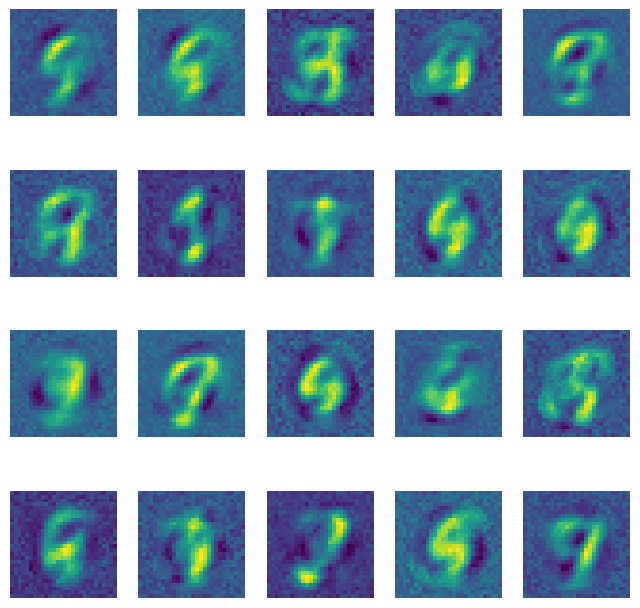

In [59]:
# Plot the Generated samples
noise_samples = torch.randn(20, latent_space).to(device)
generated_samples = generator(noise_samples).cpu().detach().numpy()

plt.figure(figsize=(8, 8))

for index, image in enumerate(generated_samples):
    plt.subplot(4, 5, index + 1)
    plt.imshow(image.reshape(28, 28))
    plt.axis("off")

plt.show()